<a href="https://colab.research.google.com/github/RandaAlsubaie/ny/blob/main/Yet_another_copy_of_Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install mplfinance
#!pip install opendatasets

# Libraries

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt


# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM

#Load Data

In [ ]:
df=pd.read_csv('/content/weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [ ]:
df = df.loc[:, ['Formatted Date','Temperature (C)']]

In [ ]:
df.sample(5)

,Formatted Date,Temperature (C)
13755,2007-06-05 03:00:00.000 +0200,16.044444
46770,2011-01-10 18:00:00.000 +0100,6.916667
93102,2016-03-21 09:00:00.000 +0100,9.822222
25444,2008-10-31 04:00:00.000 +0100,7.988889
71353,2014-08-28 01:00:00.000 +0200,13.261111


# EDA DF

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.isnull().sum()

,0
index,0
Formatted Date,0
Temperature (C),0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            96453 non-null  int64  
 1   Formatted Date   96453 non-null  object 
 2   Temperature (C)  96453 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df.describe(include='all')

,index,Formatted Date,Temperature (C)
count,96453.000000,96453,96453.000000
unique,NaN,96429,NaN
top,NaN,2010-08-02 01:00:00.000 +0200,NaN
freq,NaN,2,NaN
mean,48226.000000,NaN,11.932678
std,27843.727094,NaN,9.551546
min,0.000000,NaN,-21.822222
25%,24113.000000,NaN,4.688889
50%,48226.000000,NaN,12.000000
75%,72339.000000,NaN,18.838889


In [ ]:
df.sample(5)

,index,Formatted Date,Temperature (C)
53780,53780,2012-08-26 20:00:00.000 +0200,22.350000
27041,27041,2009-04-09 17:00:00.000 +0200,23.838889
73777,73777,2014-07-01 01:00:00.000 +0200,14.538889
52454,52454,2011-09-30 14:00:00.000 +0200,25.883333
95260,95260,2016-10-02 08:00:00.000 +0200,12.622222


#Visualization


In [ ]:
tdata  = df.set_index('Formatted Date')
tdata.index = pd.to_datetime(tdata.index,  utc=True)
tdata = tdata.resample('D').mean()

tdata = tdata.asfreq('D')

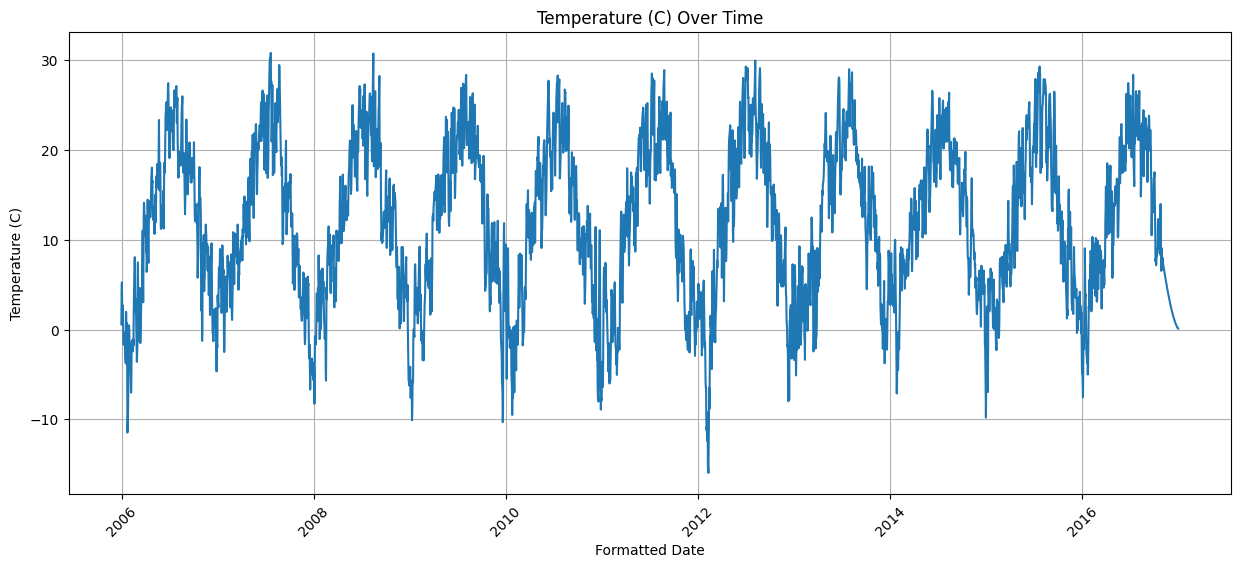

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(tdata['Temperature (C)'])
plt.title('Temperature (C) Over Time')
plt.xlabel('Formatted Date')
plt.ylabel('Temperature (C)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

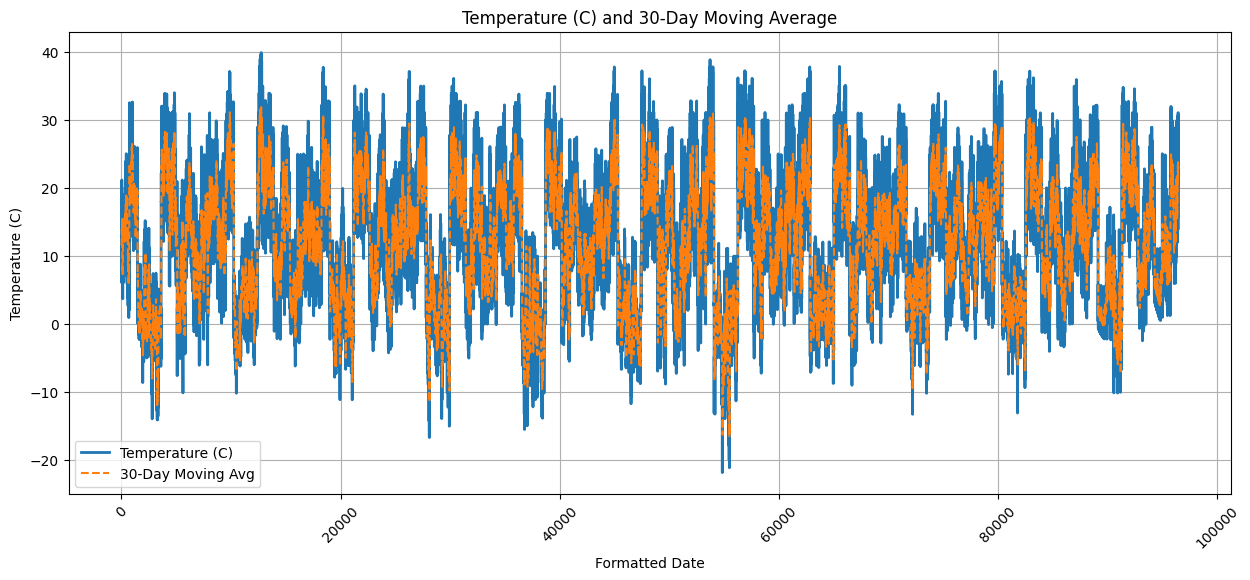

In [ ]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot( df['Temperature (C)'], label='Temperature (C)', linewidth=2)
plt.plot( df['Temperature (C)'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Temperature (C) and {window}-Day Moving Average')
plt.xlabel('Formatted Date')
plt.ylabel('Temperature (C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Preprocessing

In [ ]:
new_df = df.reset_index()['Temperature (C)']

## Normalize the values

In [ ]:
values_to_scale = df['Temperature (C)'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values_to_scale)

## Data Splitting

In [ ]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Define the window (past time steps)

In [ ]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(77102, 60)
(77102,)


Testing set size:-
(19231, 60)
(19231,)


(None, None)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Modeling

In [ ]:
model = Sequential()

model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 100)             │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 50)              │           7,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,851 (89.26 KB)

 Trainable params: 22,851 (89.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=100,
          verbose=1,
          callbacks= [ early_stopping])

Epoch 1/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.1161 - val_loss: 7.4659e-04
Epoch 2/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0059 - val_loss: 5.5628e-04
Epoch 3/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0033 - val_loss: 5.0478e-04
Epoch 4/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 5/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0019 - val_loss: 0.0012


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

2410/2410 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

14.245861022753138
14.203621747445915


## Visualization of results

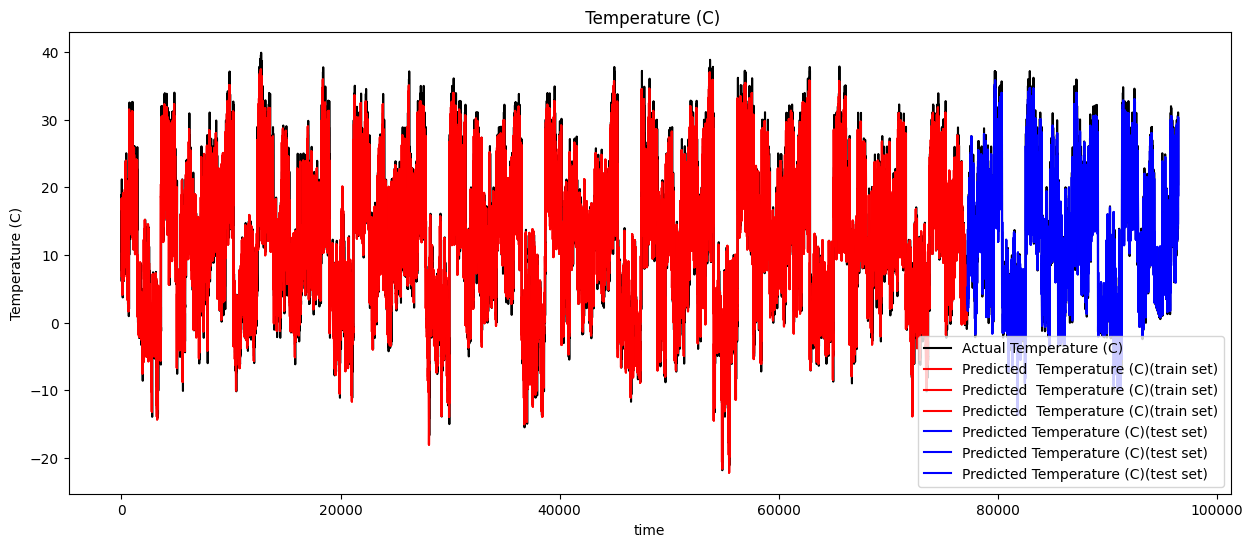

In [ ]:
look_back = 30

trainPredictPlot = np.empty_like(df)
trainPredictPlot[:] = np.nan

trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

testPredictPlot = np.empty_like(df,dtype=float)
testPredictPlot[:] = np.nan

test_start = len(df) - len(test_predict)

testPredictPlot[test_start:] = test_predict

original_scaled_data = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual Temperature (C)")
plt.plot(trainPredictPlot, color='red', label=f"Predicted  Temperature (C)(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted Temperature (C)(test set)")

plt.title(f" Temperature (C)")
plt.xlabel("time")
plt.ylabel(f"Temperature (C)")
plt.legend()
plt.show()

In [ ]:

last_sequence = X_test[-1]


last_sequence = last_sequence.reshape(1, n_past, 1)
predictions_next_15_days = []
for _ in range(15):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_15_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

predictions_next_15_days = scaler.inverse_transform(np.array(predictions_next_15_days).reshape(-1, 1))

print("Predictions for the next 15 days:")
for i, prediction in enumerate(predictions_next_15_days, start=1):
    print(f"Day {i}: Temperature (C) = {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predictions for the next 15 days:
Day 1: Temperature (C) = 18.834686279296875
Day 2: Temperature (C) = 17.197355270385742
Day 3: Temperature (C) = 15.536375045776367
Day 4: Temperature (C) = 14.11455249786377
Day 5: Temperature (C) = 12.890667915344238
Day 6: Temperature (C) = 12.054485321044922
Day 7: Temperature (C) = 11.527461051940918
Day 8: Temperature (C) = 11.732248306274414
Day 9: Temperature (C) = 12.348653793334961


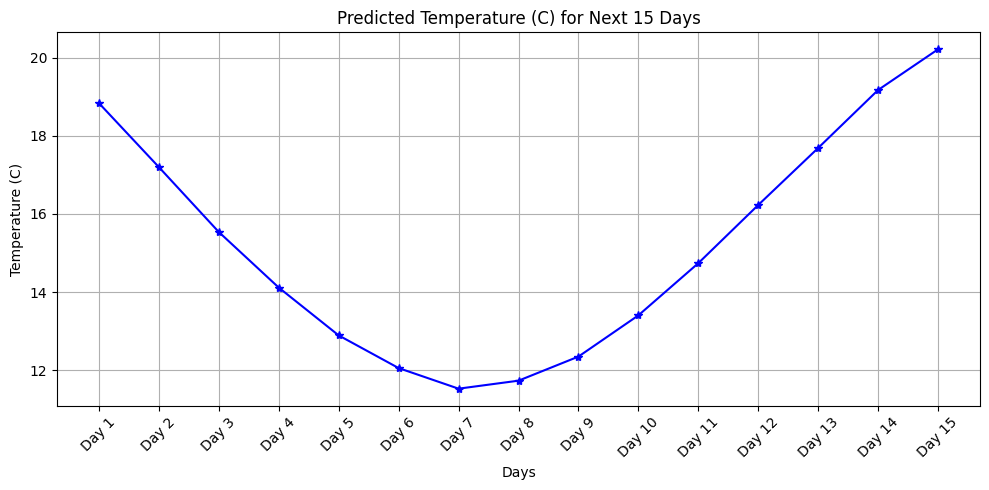

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(predictions_next_15_days, marker='*', linestyle='-', color='blue')
plt.title(f'Predicted Temperature (C) for Next 15 Days')
plt.xlabel('Days')
plt.ylabel('Temperature (C)')


plt.xticks(ticks=range(15), labels=[f'Day {i+1}' for i in range(15)], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()